In [1]:
import jax.numpy as np
from matplotlib import pyplot as plt
from jax import grad, vmap, jit, partial, random
import numpy as onp
from jax.experimental.ode import odeint
from jax.experimental import optimizers
from jax.scipy.optimize import minimize
import jax
key = random.PRNGKey(0)
import pickle
from jax.lax import fori_loop, scan
from jax.config import config
# config.update("jax_enable_x64", True)

/opt/anaconda3/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Neural ODE constitutive model

## Constitutive modeling

When modeling a hyperelastic material from a mechanical perspective, we would like to define a strain energy function:
$$\Psi(I_1, I_2, ...,I_n)$$
Where $I_i$ represent the invariants of the right Cauchy deformation tensor. One desired property of this function is convexity. This is important because it guarantees that the material always a non-negative stiffness. To satisfy convexity, we have 2 equivalent options:

- the second derivative (stiffness) is always non-negative.
- the first derivative monotonically increases with respect to the input.

A very commonly used form of $\Psi$ is based on an additive decomposition:
$$\Psi(I_1, I_2, ...,I_n) = \sum_i^n \Psi_i(I_i)$$
In this particular case, to satisfy convexity, we just need $\frac{\delta \Psi_i}{\delta I_i}$ to be monotonically increasing.


## Neural networks for constitutive modeling

In this context, we would like to approximate $\Psi$ with a neural network to avoid the need of choosing a particular form of the equation. And to satisfy the convexity requirement, we would like the approximate $\frac{\delta \Psi_i}{\delta I_i}$  with a neural network that monotonically increases. This can be satisfied with a neural ordinary differential equation [1], which has the form:

$$\boldsymbol{y} = \boldsymbol{x} + \int_0^T f(\boldsymbol{h}(t),t,\boldsymbol{\theta})dt$$

where $f(\boldsymbol{h}(t),t,\boldsymbol{\theta})$ is a neural network that represents the right hand side of an ODE. This mapping from $\boldsymbol{x}$ to $\boldsymbol{y}$ must monotonically increase or decrease following this reasoning:
- For the kind of neural network that we use for right hand side of the ODE, we can guarantee that there is a unique solution for every initial condition. This means, in our context, that for every input there is a unique output [1].
- But, we can also integrate the system backwards in time, meaning that we can use the output as an initial condition to go to the input. And from what we just said, there must be a unique input for every output. This means we can invert the system $y = g(x),\, x = g^{-1}(y)$. 
- If a function can be inverted, it must monotonically increase or decrease.
- Another way to interpret this, is to consider trajectories (solutions of the ODE) never cross each other. 

The idea is to approximate $\frac{\delta \Psi_i}{\delta I_i}$ with a neural ODE. But in general, any invertible architecture should work. 
$$\frac{\delta \Psi_i}{\delta I_i} = I_i + \int_0^T f(\boldsymbol{h}(t),t,\boldsymbol{\theta})dt$$
$$\boldsymbol{h}(0) = I_i$$

The hope is that data with steer the function to be monotonically increasing instead of decreasing.

If we want to compute the tangent stiffness matrix, which involves $\frac{\delta^2 \Psi_i}{\delta I_i^2}$, this can done efficiently with the adjoint method. 

In the rare case that would like to evaluate the strain energy function, we would have to do it numerically.






In [2]:
load_existing_model = False
model_name = 'P12AC1_xybsxsy'
dataset_name = 'P12AC1_xybsxsy'
#P1C1: n_offx = n_offy = 61, n_equi = n_strx = n_stry = 0
#S111S1: n_offx = n_offy = n_equi = 183, n_strx = n_stry = 0
#P12AC1: n_offx = 72, n_offy = 76, n_equi = 81, n_strx = 101, n_stry = 72
#P12BC2: n_offx = 76, n_offy = 76, n_equi = 95, n_strx = 101, n_stry = 84
#Unless you are working with multifidelity data, set all of the following to 0.
n_offx = 0
n_offy = 0
n_equi = 0
n_strx = 0
n_stry = 0
n_hf = n_offx + n_offy + n_equi + n_strx + n_stry

with open('training_data/' + dataset_name + '.npy', 'rb') as f:
    lamb, sigma_gt = np.load(f,allow_pickle=True)
n_data = lamb.shape[0]
weights = onp.ones([n_data,1])
weights[:n_hf] = 10 #Weight of high fidelity loss
#sigma_gt = np.concatenate((sigma_gt.transp,weights), axis=0)
sigma_gt = np.hstack((sigma_gt,weights))

In [3]:
# A generic function to compute the stress given the princial stretches
# this will be used later for the NN
@partial(jit, static_argnums=(4))
def sigma(lamb1, lamb2, lamb3, p, NN, params):
    I1_params, I2_params, Iv_params, Iw_params, J1_params, J2_params, J3_params, J4_params, J5_params, J6_params, \
        I_weights, theta, Psi1_bias, Psi2_bias = params
    
    a = 1/(1+np.exp(-I_weights))
    
    v0 = np.array([ np.cos(theta), np.sin(theta), 0])
    w0 = np.array([-np.sin(theta), np.cos(theta), 0])
    F = np.array([[lamb1, 0, 0],
                  [0, lamb2, 0],
                  [0, 0, lamb3]])
    v = np.dot(F, v0)
    w = np.dot(F, w0)
    b = np.dot(F, F.T)
    I1 = np.trace(b)
    b2 = np.einsum('ij,jk->ik', b, b)
    I2 = 0.5*(np.trace(b)**2 - np.trace(b2)) # again assuming is diagonal
    Iv = np.sum(b*np.outer(v0,v0)) 
    Iw = np.sum(b*np.outer(w0,w0)) 
    
    I1 = I1-3
    I2 = I2-3
    Iv = Iv-1
    Iw = Iw-1
    J1 = a[0]*I1+(1-a[0])*I2
    J2 = a[1]*I1+(1-a[1])*Iv
    J3 = a[2]*I1+(1-a[2])*Iw
    J4 = a[3]*I2+(1-a[3])*Iv
    J5 = a[4]*I2+(1-a[4])*Iw
    J6 = a[5]*Iv+(1-a[5])*Iw
    
    #Iv, Iw, J1, J2, J3, J4, J5, J6 = 0.,0.,0.,0.,0.,0.,0.,0.
    
    Psi1 = NN(I1,  I1_params)
    Psi2 = NN(I2,  I2_params)
    Psiv = NN(Iv,  Iv_params)
    Psiw = NN(Iw,  Iw_params)
    Phi1 = NN(J1,  J1_params)
    Phi2 = NN(J2,  J2_params)
    Phi3 = NN(J3,  J3_params)
    Phi4 = NN(J4,  J4_params)
    Phi5 = NN(J5,  J5_params)
    Phi6 = NN(J6,  J6_params)
    
    Psiv = np.max([Psiv, 0])
    Psiw = np.max([Psiw, 0])
    Phi1 = np.max([Phi1, 0])
    Phi2 = np.max([Phi2, 0])
    Phi3 = np.max([Phi3, 0])
    Phi4 = np.max([Phi4, 0])
    Phi5 = np.max([Phi5, 0])
    Phi6 = np.max([Phi6, 0])
    
    Psi1 = Psi1 +     a[0]*Phi1 +     a[1]*Phi2 +     a[2]*Phi3 + np.exp(Psi1_bias)
    Psi2 = Psi2 + (1-a[0])*Phi1 +     a[3]*Phi4 +     a[4]*Phi5 + np.exp(Psi2_bias)
    Psiv = Psiv + (1-a[1])*Phi2 + (1-a[3])*Phi4 +     a[5]*Phi6
    Psiw = Psiw + (1-a[2])*Phi3 + (1-a[4])*Phi5 + (1-a[5])*Phi6
    
    return -p*np.eye(3) + 2*Psi1*b + 2*Psi2*((I1+3)*b - b**2) + 2*Psiv*np.outer(v,v) + 2*Psiw*np.outer(w,w)

In [4]:
# a wrapper to compute biaxial stresses easily
@partial(jit, static_argnums=(1))
def sigma_biaxial(lamb, NN, params):
    # incompressibility
    lamb3 = 1/(lamb[0]*lamb[1])
    # use \sigma_33 = 0 to compute pressure
    p = sigma(lamb[0], lamb[1], lamb3, 0, NN, params)[2,2]
    # return \sigma_11 and \sigma_22
    return sigma(lamb[0], lamb[1], lamb3, p, NN, params)[[0,1],[0,1]]
# in jax we do everything for one value and then vectorize with vmap
sigma_biaxial_vmap = vmap(sigma_biaxial, in_axes=(0,None, None), out_axes=0)

In [5]:
# Fully connected neural network code
def init_params(layers, key):
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    return Ws

@jit
def forward_pass(H, Ws):
    N_layers = len(Ws)
    for i in range(N_layers - 1):
        H = np.matmul(H, Ws[i])
        H = np.tanh(H)
        Y = np.matmul(H, Ws[-1])
    return Y

@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, Y, opt_state, key, nIter = 10000, batch_size = 10):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, it, opt_state, X[idx_batch], Y[idx_batch])         
        if it % 1000 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

In [6]:
@jit
def ODEforward_pass(y0, params):
    f = lambda y, t: forward_pass(np.array([y]),params) # fake time argument for ODEint
    return odeint(f, y0, np.array([0.0,1.0]))[-1] # integrate between 0 and 1 and return the results at 1

def Eulerforward_pass(y0, params, steps = 10):
    body_func = lambda y, i: (y + forward_pass(np.array([y]), params)[0], None)
    out, _ = scan(body_func, y0, None, length = steps)
    return out

@jit
def loss(params, lamb, sigma_gt):
    sigma_pred = sigma_biaxial_vmap(lamb, Eulerforward_pass, params)
    J_weights = params[10]
    #sigma_gt[:,2] contains the weights of multifidelity data. i.e. sigma_gt[:,2] = 1 for low fidelity and 10 for high fidelity.
    dummy1 = sigma_pred[:,0]
    dummy2 = sigma_gt[:,0]
    dummy3 = sigma_gt[:,2]
    
    #transform to log space:
#     dummy1 = np.log(dummy1)
#     dummy2 = np.log(dummy2)
    loss_MSE = np.average((dummy1 - dummy2)**2*dummy3)
                          
    dummy1 = sigma_pred[:,1]
    dummy2 = sigma_gt[:,1]
#     dummy1 = np.log(dummy1)
#     dummy2 = np.log(dummy2)
    loss_MSE+= np.average((dummy1 - dummy2)**2*dummy3)
    
#     loss_L1 = np.array(1.0e-5*np.sum(np.abs(J_weights)), dtype = np.float64)
#    loss_L1 = 1.0e-5*np.sum(np.abs(J_weights))
    return  loss_MSE# + loss_L1

layers = [1, 5, 5, 1]

W1_params = init_params(layers, key)
W2_params = init_params(layers, key)
W4v_params = init_params(layers, key)
W4w_params = init_params(layers, key)
J1_params = init_params(layers, key)
J2_params = init_params(layers, key)
J3_params = init_params(layers, key)
J4_params = init_params(layers, key)
J5_params = init_params(layers, key)
J6_params = init_params(layers, key)
I_weights = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
theta = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0

params = (W1_params, W2_params, W4v_params, W4w_params, J1_params, J2_params, J3_params, J4_params, J5_params, J6_params, I_weights, \
          theta, Psi1_bias, Psi2_bias)


opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(params)

if load_existing_model == False:
    if lamb.shape[0] > 100:
        batch_size = 100
    else:
        batch_size = lamb.shape[0]
    
    params, train_loss, val_loss = train(loss,lamb, sigma_gt, opt_state, key, nIter = 100000, batch_size = batch_size)
    with open('savednet/' + model_name + '.npy', 'wb') as f:
        pickle.dump(params, f)
else:
    with open('savednet/' + model_name + '.npy', 'rb') as f:
        params = pickle.load(f)


/opt/anaconda3/lib/python3.8/site-packages/jax/numpy/lax_numpy.py:1674: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


it 0, train loss = 2.740803e+03
it 1000, train loss = 2.062826e+01
it 2000, train loss = 2.791958e+00
it 3000, train loss = 9.821215e-01
it 4000, train loss = 4.325727e-01
it 5000, train loss = 2.090407e-01
it 6000, train loss = 1.048423e-01
it 7000, train loss = 5.411229e-02
it 8000, train loss = 2.900513e-02
it 9000, train loss = 1.684631e-02
it 10000, train loss = 1.136475e-02
it 11000, train loss = 9.061614e-03
it 12000, train loss = 8.109624e-03
it 13000, train loss = 7.486998e-03
it 14000, train loss = 6.647469e-03
it 15000, train loss = 5.705388e-03
it 16000, train loss = 5.008101e-03
it 17000, train loss = 4.479528e-03
it 18000, train loss = 3.965397e-03
it 19000, train loss = 3.485698e-03
it 20000, train loss = 3.052557e-03
it 21000, train loss = 2.682227e-03
it 22000, train loss = 2.408319e-03
it 23000, train loss = 2.243929e-03
it 24000, train loss = 2.170957e-03
it 25000, train loss = 2.117228e-03
it 26000, train loss = 2.041383e-03
it 27000, train loss = 1.999774e-03
it 28

In [7]:
sigma_pred = sigma_biaxial_vmap(lamb, Eulerforward_pass, params)#ODEforward_pass, params)

error = onp.zeros(sigma_gt.shape[0])
rel_error = onp.zeros(sigma_gt.shape[0])
dummy = onp.zeros(sigma_gt.shape[0])
for i in range(sigma_gt.shape[0]):
    for j in range(2):
        error[i]+= (sigma_gt[i,j] - sigma_pred[i,j])**2
        dummy[i]+= sigma_gt[i,j]**2 
    error[i] = onp.sqrt(error[i])
    dummy[i] = onp.sqrt(dummy[i])
    rel_error[i] = error[i]/dummy[i]
offx_error = onp.sum(error[:n_offx])/n_offx
offy_error = onp.sum(error[n_offx:n_offx+n_offy])/n_offy
equi_error = onp.sum(error[n_offx+n_offy:n_offx+n_offy+n_equi])/n_equi
synt_error = onp.sum(error[n_hf:])/(n_data-n_hf)

offx_rel_error = rel_error[:n_offx]
offx_rel_error = offx_rel_error[onp.isfinite(offx_rel_error)]
offx_rel_error = onp.mean(offx_rel_error)
offy_rel_error = rel_error[n_offx:n_offx+n_offy]
offy_rel_error = offy_rel_error[onp.isfinite(offy_rel_error)]
offy_rel_error = onp.mean(offy_rel_error)
equi_rel_error = rel_error[n_offx+n_offy:n_offx+n_offy+n_equi]
equi_rel_error = equi_rel_error[onp.isfinite(equi_rel_error)]
equi_rel_error = onp.mean(equi_rel_error)
synt_rel_error = rel_error[n_hf:]
synt_rel_error = synt_rel_error[onp.isfinite(synt_rel_error)]
synt_rel_error = onp.mean(synt_rel_error)

if n_hf>0:
    fig = plt.figure(figsize=(16,5))
    fig.subplots_adjust(top=0.75)
    ax1 = fig.add_subplot(131)
    ax1.plot(lamb[:n_offx,1],   sigma_gt[:n_offx,0],'b.', label = '$\sigma_{xx}$')
    ax1.plot(lamb[:n_offx,1], sigma_pred[:n_offx,0],'b--')
    ax1.plot(lamb[:n_offx,1],   sigma_gt[:n_offx,1],'b.', label = '$\sigma_{yy}$')
    ax1.plot(lamb[:n_offx,1], sigma_pred[:n_offx,1],'b--')
    title = 'Off-x \nAvg abs error: %f \nAvg rel error: %f' %(offx_error, offx_rel_error)
    ax1.set(xlabel = '$\lambda_{yy}$', ylabel = '$\sigma$', title=title)
    ax1.legend()

    ax2 = fig.add_subplot(132)
    ax2.plot(lamb[n_offx:n_offx + n_offy,1],   sigma_gt[n_offx:n_offx + n_offy,0],'r.')
    ax2.plot(lamb[n_offx:n_offx + n_offy,1], sigma_pred[n_offx:n_offx + n_offy,0],'r--')
    ax2.plot(lamb[n_offx:n_offx + n_offy,1],   sigma_gt[n_offx:n_offx + n_offy,1],'r.')
    ax2.plot(lamb[n_offx:n_offx + n_offy,1], sigma_pred[n_offx:n_offx + n_offy,1],'r--')
    title = 'Off-y \nAvg abs error: %f \nAvg rel error: %f' %(offy_error, offy_rel_error)
    ax2.set(xlabel = '$\lambda_{yy}$', ylabel = '$\sigma$', title=title)

    ax3 = fig.add_subplot(133)
    ax3.plot(lamb[n_offx + n_offy:n_hf  ,1],   sigma_gt[n_offx + n_offy:n_hf  ,0],'g.')
    ax3.plot(lamb[n_offx + n_offy:n_hf  ,1], sigma_pred[n_offx + n_offy:n_hf  ,0],'g--')
    ax3.plot(lamb[n_offx + n_offy:n_hf  ,1],   sigma_gt[n_offx + n_offy:n_hf  ,1],'g.')
    ax3.plot(lamb[n_offx + n_offy:n_hf  ,1], sigma_pred[n_offx + n_offy:n_hf  ,1],'g--')
    title = 'Off-y \nAvg abs error: %f \nAvg rel error: %f' %(equi_error, equi_rel_error)
    ax3.set(xlabel = '$\lambda_{yy}$', ylabel = '$\sigma$', title=title)
    plt.suptitle('Experimental Data')
    plt.subplots_adjust(wspace=0.3)


<ipython-input-7-a23c941d10f0>:13: RuntimeWarning: invalid value encountered in double_scalars
  offx_error = onp.sum(error[:n_offx])/n_offx
<ipython-input-7-a23c941d10f0>:14: RuntimeWarning: invalid value encountered in double_scalars
  offy_error = onp.sum(error[n_offx:n_offx+n_offy])/n_offy
<ipython-input-7-a23c941d10f0>:15: RuntimeWarning: invalid value encountered in double_scalars
  equi_error = onp.sum(error[n_offx+n_offy:n_offx+n_offy+n_equi])/n_equi
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


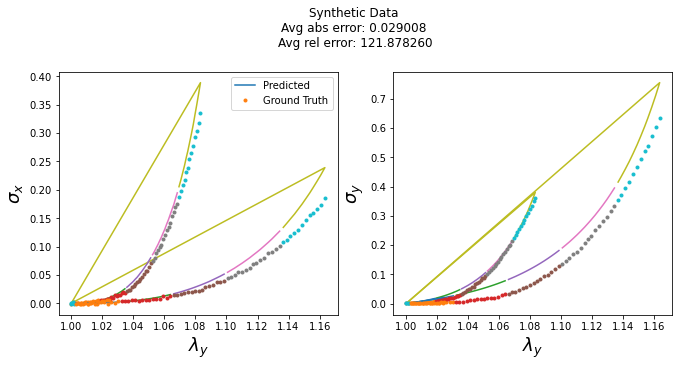

In [8]:
if n_data > n_hf: #ndata = n_hf would mean there is no synthetic data
    res1 = 11
    res2 = 4
    res3 = 11
    
    fig = plt.figure()
    fig.set_size_inches((11,5))
    plt.subplot(121)
    fig.subplots_adjust(top=0.8)
    for i in range(res1):
        i1 = n_hf + i*(res2+res3)
        i2 = n_hf + (i+1)*(res2+res3)
        plt.plot(lamb[i1:i2,1], sigma_pred[i1:i2,0])
        plt.plot(lamb[i1:i2,1],   sigma_gt[i1:i2,0]  ,'.')
    plt.xlabel('$\lambda_y$', fontsize=18)
    plt.ylabel('$\sigma_x$', fontsize=18)
    plt.legend(('Predicted', 'Ground Truth'))
    
    plt.subplot(122)
    for i in range(res1):
        i1 = n_hf + i*(res2+res3)
        i2 = n_hf + (i+1)*(res2+res3)
        plt.plot(lamb[i1:i2,1], sigma_pred[i1:i2,1])
        plt.plot(lamb[i1:i2,1],   sigma_gt[i1:i2,1] ,'.')
    plt.xlabel('$\lambda_y$', fontsize=18)
    plt.ylabel('$\sigma_y$', fontsize=18)
    plt.suptitle('Synthetic Data \nAvg abs error: %f \nAvg rel error: %f' %(synt_error, synt_rel_error*100))
    plt.show()